In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import Dense, Flatten, Input # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import SGD #optimisers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical #some function for data preparation


from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

In [2]:
# Read in MNIST data
(X_train_all, y_train_all), (X_test_all, y_test_all) = mnist.load_data()
print(np.shape(X_train_all))
print(np.shape(y_train_all))
print(np.shape(X_test_all))
print(np.shape(y_test_all))


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### (1) Construct Combined Dataset

In [3]:
# Create a function to combine two images and their labels
def gen_combined_data(images, labels, num_samples):
    """
    Generates a dataset of combined MNIST images and their corresponding sum labels.

    This function randomly pairs two images from the input dataset, stacks them vertically 
    to create a new image of dimensions (56, 28), and calculates the sum of their labels 
    as the target value.

    Args:
        images (numpy.ndarray): Array of shape (num_samples, 28, 28) containing grayscale images.
        labels (numpy.ndarray): Array of shape (num_samples,) containing the numeric labels of the images.
        num_samples (int): The number of combined image-label pairs to generate.

    Returns:
        tuple: A tuple containing:
            - combined_images (numpy.ndarray): Array of shape (num_samples, 56, 28) containing vertically stacked images.
            - combined_labels (numpy.ndarray): Array of shape (num_samples,) containing the sum of the paired labels.
    """
    combined_images = []
    combined_labels = []
    for _ in range(num_samples):
        # Randomly pick two indices
        x1, x2 = np.random.randint(0, len(images), size=2)
        # Stack two images vertically
        combined_image = np.vstack((images[x1], images[x2]))
        # Sum the labels
        combined_label = labels[x1] + labels[x2]
        # Append to the dataset
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
    return np.array(combined_images), np.array(combined_labels)

In [4]:
# Define the number of samples for each dataset
n_test = 10000
n_train = 60000
n_val = 10000

batch_size = 128
epochs = 40

# input image dimensions
img_rows, img_cols = 28, 28

X_train_all = X_train_all.astype('float32') 
X_test_all = X_test_all.astype('float32')
X_train_all /= 255
X_test_all /= 255

# Generate the combined datasets
X_train_comb, y_train_comb = gen_combined_data(X_train_all, y_train_all, n_train)

X_val_comb, y_val_comb = gen_combined_data(X_train_all, y_train_all, n_val)  # Drawn from same distribution as training data, but not the same data

X_test_comb, y_test_comb = gen_combined_data(X_test_all, y_test_all, n_test)

num_classes = 19 # possible sums equal to 0-18

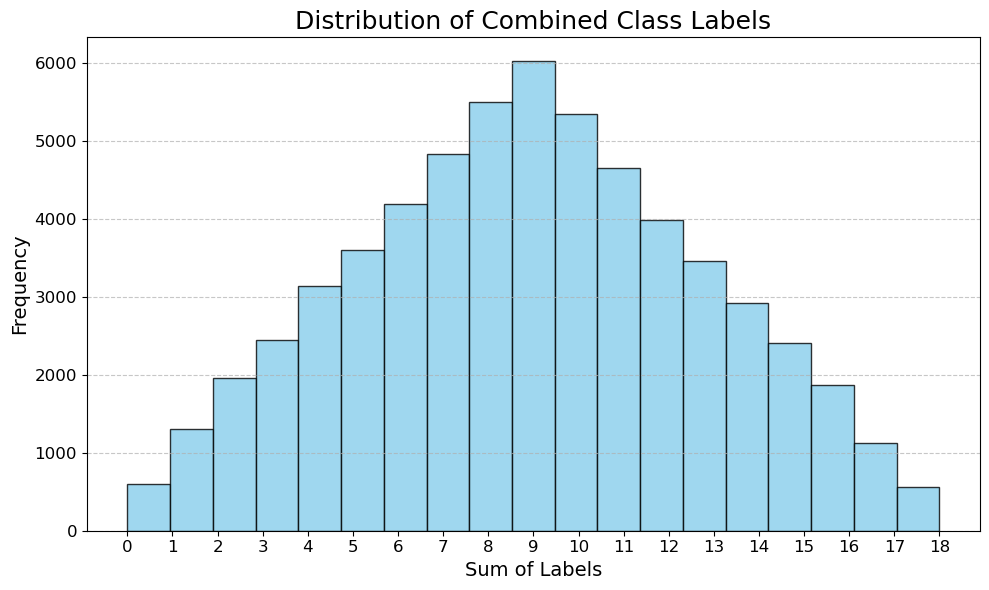

In [5]:
# Create the histogram to show the distribution of the combined labels
plt.figure(figsize=(10, 6))
plt.hist(y_train_comb, bins=19, range=(0, 18), color='skyblue', edgecolor='black', alpha=0.8)

plt.title('Distribution of Combined Class Labels', fontsize=18)
plt.xlabel('Sum of Labels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.xticks(range(0, 19), fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('combined_labels_distribution.png')
plt.show()

### (2) Creation of Neural Network and Optimisation

In [6]:
# convert class vectors to binary class matrices (one-hot encoding)
y_train_comb_cat = to_categorical(y_train_comb, num_classes)
y_test_comb_cat = to_categorical(y_test_comb, num_classes)
y_val_comb_cat = to_categorical(y_val_comb, num_classes)

In [7]:
#Flatten data
X_train_comb_flat = X_train_comb.reshape(X_train_comb.shape[0], -1)
X_test_comb_flat = X_test_comb.reshape(X_test_comb.shape[0], -1)
X_val_comb_flat = X_val_comb.reshape(X_val_comb.shape[0], -1)

In [8]:
# Define functions for model creation and optimisation

def create_model(trial):
    # Define the model architecture
    input_network = Input(shape=(56, 28))
    x = Flatten()(input_network)
    # Suggest the number of layers and units in each layer
    n_layers = trial.suggest_int('n_layers', 1, 6)
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 50, 200)
        activation = trial.suggest_categorical(f'activation_l{i}', ['relu', 'tanh', 'sigmoid'])
        x = Dense(n_units, activation=activation)(x)
        dropout_rate = trial.suggest_float(f'dropout_l{i}', 0.1, 0.5)
       
        x = Dropout(rate=dropout_rate)(x)
    
    y = Dense(num_classes, activation='softmax')(x)
    
    model = Model(input_network, outputs=y)
    
    # Suggest the learning rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    opt = Adam(learning_rate=learning_rate)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

def objective(trial):
    model = create_model(trial)
    
    # Train the model
    history = model.fit(
        X_train_comb, y_train_comb_cat,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(X_val_comb, y_val_comb_cat)
    )

    # Evaluate the model
    score = model.evaluate(X_test_comb, y_test_comb_cat, verbose=0)
    return score[1]

In [9]:
def create_nn(optuna_params):
    """
    Creates a Keras Sequential model based on parameters optimized by Optuna.

    Parameters:
    - optuna_params (dict): Dictionary of parameters optimized by Optuna.
    Returns:
    - model (tf.keras.Model): Compiled Keras model.
    """
    # Extract basic architecture information
    n_layers = optuna_params["n_layers"]
    input_dim = (56,28)
    output_units = 19
   
    # Start building the model
    model = Sequential()
    #Add input layer
    model.add(Flatten(input_shape=(56, 28)))    

    # Hidden layers
    for i in range(n_layers):
        hidden_units = optuna_params[f"n_units_l{i}"]
        activation = optuna_params[f"activation_l{i}"]
        dropout_rate = optuna_params.get(f"dropout_l{i}", 0.0)  # Default to 0 if not specified

        model.add(Dense(hidden_units, activation=activation))
        model.add(Dropout(rate=dropout_rate))

    # Output layer
    model.add(Dense(output_units, activation="softmax"))

    # Compile the model
    optimizer_name = optuna_params.get("optimizer", "adam")
    learning_rate = optuna_params.get("learning_rate", 0.001)

    optimizer = tf.keras.optimizers.get(optimizer_name)
    optimizer.learning_rate = learning_rate

    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    return model

In [99]:
# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-12-11 16:15:29,579] A new study created in memory with name: no-name-3cf50125-c401-4e8e-a1f0-87b59050e571


[I 2024-12-11 16:16:02,326] Trial 0 finished with value: 0.7975999712944031 and parameters: {'n_layers': 2, 'n_units_l0': 185, 'activation_l0': 'tanh', 'dropout_l0': 0.3046804632457857, 'n_units_l1': 92, 'activation_l1': 'tanh', 'dropout_l1': 0.3959053577989608, 'learning_rate': 0.0003488948747224087}. Best is trial 0 with value: 0.7975999712944031.
[I 2024-12-11 16:16:44,934] Trial 1 finished with value: 0.894599974155426 and parameters: {'n_layers': 5, 'n_units_l0': 101, 'activation_l0': 'sigmoid', 'dropout_l0': 0.15813331106303827, 'n_units_l1': 84, 'activation_l1': 'sigmoid', 'dropout_l1': 0.37977726383332794, 'n_units_l2': 171, 'activation_l2': 'relu', 'dropout_l2': 0.15039594274028945, 'n_units_l3': 184, 'activation_l3': 'tanh', 'dropout_l3': 0.28077743089769014, 'n_units_l4': 177, 'activation_l4': 'relu', 'dropout_l4': 0.40010730523350363, 'learning_rate': 0.003021166928262639}. Best is trial 1 with value: 0.894599974155426.
[I 2024-12-11 16:17:15,043] Trial 2 finished with valu

Best trial:
  Value: 0.9074000120162964
  Params: 
    n_layers: 6
    n_units_l0: 188
    activation_l0: sigmoid
    dropout_l0: 0.1394966705060745
    n_units_l1: 168
    activation_l1: tanh
    dropout_l1: 0.29363463799575207
    n_units_l2: 58
    activation_l2: relu
    dropout_l2: 0.10978858304057626
    n_units_l3: 75
    activation_l3: sigmoid
    dropout_l3: 0.16774843343352475
    n_units_l4: 182
    activation_l4: tanh
    dropout_l4: 0.32714979866710947
    n_units_l5: 159
    activation_l5: tanh
    dropout_l5: 0.199218601113753
    learning_rate: 0.003008258295174225


In [100]:
#Create optimal model 
model_opt = create_nn(trial.params)
# Print model summary
model_opt.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_142 (Flatten)       (None, 1568)              0         
                                                                 
 dense_624 (Dense)           (None, 188)               294972    
                                                                 
 dropout_482 (Dropout)       (None, 188)               0         
                                                                 
 dense_625 (Dense)           (None, 168)               31752     
                                                                 
 dropout_483 (Dropout)       (None, 168)               0         
                                                                 
 dense_626 (Dense)           (None, 58)                9802      
                                                                 
 dropout_484 (Dropout)       (None, 58)               

In [101]:
# Save the model
model_opt.save('model_opt.h5')

In [10]:
#read in model
model_opt = tf.keras.models.load_model('model_opt.h5')

In [11]:
#Train model on combined data and save history
history_opt=model_opt.fit(X_train_comb, y_train_comb_cat,
          batch_size=batch_size,
          epochs=40,
          verbose=1,
          validation_data=(X_val_comb, y_val_comb_cat))

Epoch 1/40


2024-12-11 17:09:18.708207: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 2s 3ms/step - loss: 2.2685 - accuracy: 0.1932 - val_loss: 1.6562 - val_accuracy: 0.4096
Epoch 2/40
469/469 [==============================] - 1s 3ms/step - loss: 1.4648 - accuracy: 0.5008 - val_loss: 0.9333 - val_accuracy: 0.7366
Epoch 3/40
469/469 [==============================] - 1s 3ms/step - loss: 0.9702 - accuracy: 0.7162 - val_loss: 0.6681 - val_accuracy: 0.8290
Epoch 4/40
469/469 [==============================] - 1s 3ms/step - loss: 0.7786 - accuracy: 0.7866 - val_loss: 0.6168 - val_accuracy: 0.8473
Epoch 5/40
469/469 [==============================] - 1s 3ms/step - loss: 0.6768 - accuracy: 0.8199 - val_loss: 0.5401 - val_accuracy: 0.8649
Epoch 6/40
469/469 [==============================] - 1s 3ms/step - loss: 0.6123 - accuracy: 0.8402 - val_loss: 0.5357 - val_accuracy: 0.8708
Epoch 7/40
469/469 [==============================] - 1s 3ms/step - loss: 0.5653 - accuracy: 0.8549 - val_loss: 0.4984 - val_accuracy: 0.8829
Epoch 8/40
469/46

In [12]:
#Predict on test data
test_loss, test_accuracy = model_opt.evaluate(X_test_comb, y_test_comb_cat, verbose=0)

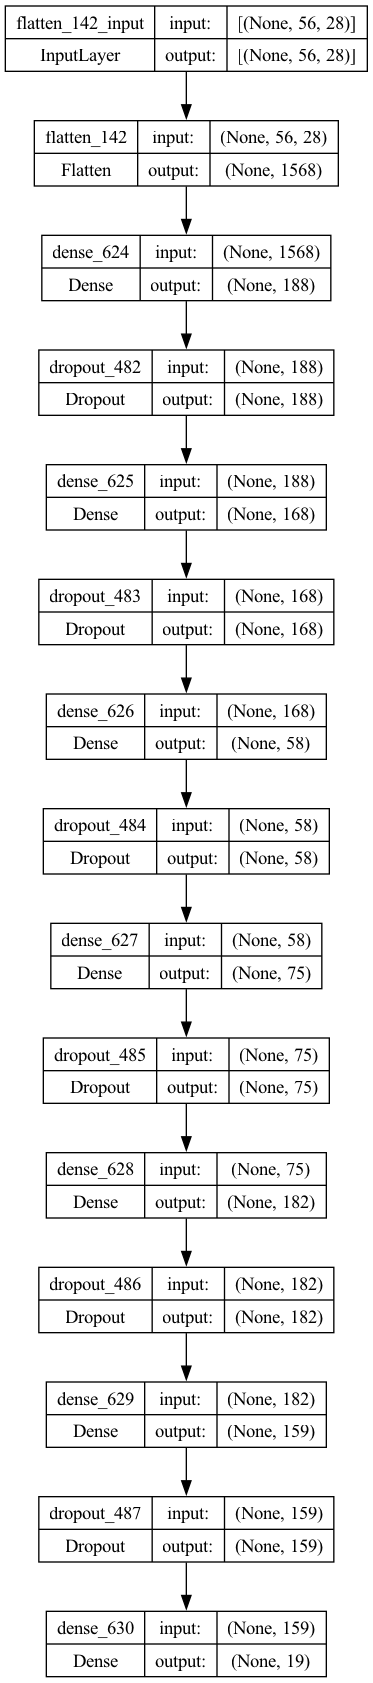

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model_opt, to_file="model_plot.png", show_shapes=True, show_layer_names=True)


In [14]:
# Print the test accuracy
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.9085999727249146


In [15]:
#Get weights
weights = model_opt.get_weights()
#Save weights
np.save('weights.npy', weights)


/opt/anaconda3/envs/tf_env/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


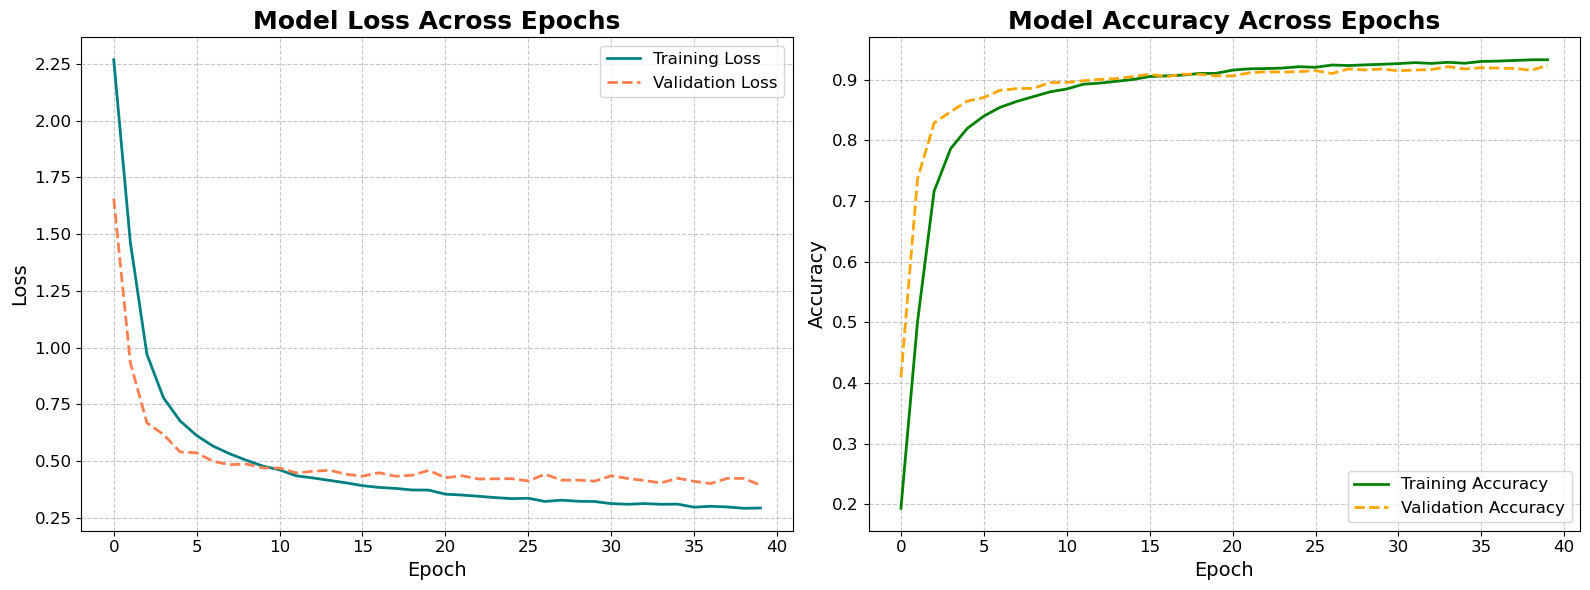

In [16]:
import matplotlib.pyplot as plt

# Create subplots for loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Two plots side-by-side

# Plot training and validation loss
ax[0].plot(history_opt.history['loss'], label='Training Loss', color='teal', linewidth=2, linestyle='-')
ax[0].plot(history_opt.history['val_loss'], label='Validation Loss', color='coral', linewidth=2, linestyle='--')
ax[0].set_title('Model Loss Across Epochs', fontsize=18, fontweight='bold')
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12, title_fontsize=14, loc='upper right', frameon=True)
ax[0].grid(True, linestyle='--', alpha=0.7)

# Plot training and validation accuracy
ax[1].plot(history_opt.history['accuracy'], label='Training Accuracy', color='green', linewidth=2, linestyle='-')
ax[1].plot(history_opt.history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2, linestyle='--')
ax[1].set_title('Model Accuracy Across Epochs', fontsize=18, fontweight='bold')
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12, title_fontsize=14, loc='lower right', frameon=True)
ax[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('model_performance.png')
# Show the plots
plt.show()


313/313 [==============================] - 0s 460us/step


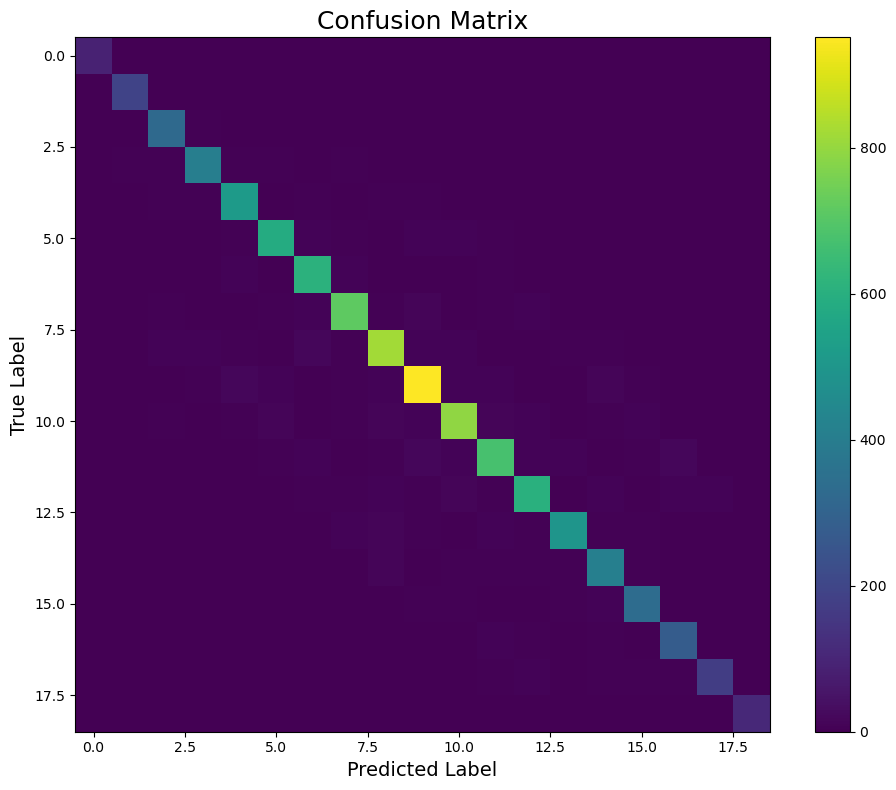

In [17]:
#Show confusion matrix
from sklearn.metrics import confusion_matrix

# Predict the class labels
y_pred = model_opt.predict(X_test_comb)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_comb, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
plt.title('Confusion Matrix', fontsize=18)
plt.colorbar()
plt.grid(False)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


### (3) Performance of other inference algorithms 

In [30]:
# Support Vector Machine
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
# Scale the data
scaler = StandardScaler()
X_train_comb_flat_scaled = scaler.fit_transform(X_train_comb_flat)
X_val_comb_flat_scaled = scaler.transform(X_val_comb_flat)
X_test_comb_flat_scaled = scaler.transform(X_test_comb_flat)

#Create smaller subsets
X_train_comb_flat_scaled_small = X_train_comb_flat_scaled[:10000]
y_train_comb_small = y_train_comb[:10000]
X_val_comb_flat_scaled_small = X_val_comb_flat_scaled[:1000]
y_val_comb_small = y_val_comb[:1000]
X_test_comb_flat_scaled_small = X_test_comb_flat_scaled[:1000]
y_test_comb_small = y_test_comb[:1000]




In [40]:
#Try different values of C
#C_values = [0.001, 0.01, 0.1, 1, 10]
C_values = np.logspace(-5, 2, 8)
val_accuracies = []
test_accuracies = []

for C in tqdm(C_values):
    # Create and fit the model
    svm_model = SVC(kernel='rbf', C=C)
    svm_model.fit(X_train_comb_flat_scaled_small, y_train_comb_small)
    
    # Evaluate on validation and test sets
    val_accuracy = svm_model.score(X_val_comb_flat_scaled_small, y_val_comb_small)
    test_accuracy = svm_model.score(X_test_comb_flat_scaled_small, y_test_comb_small)
    
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)


100%|██████████| 8/8 [08:25<00:00, 63.20s/it]


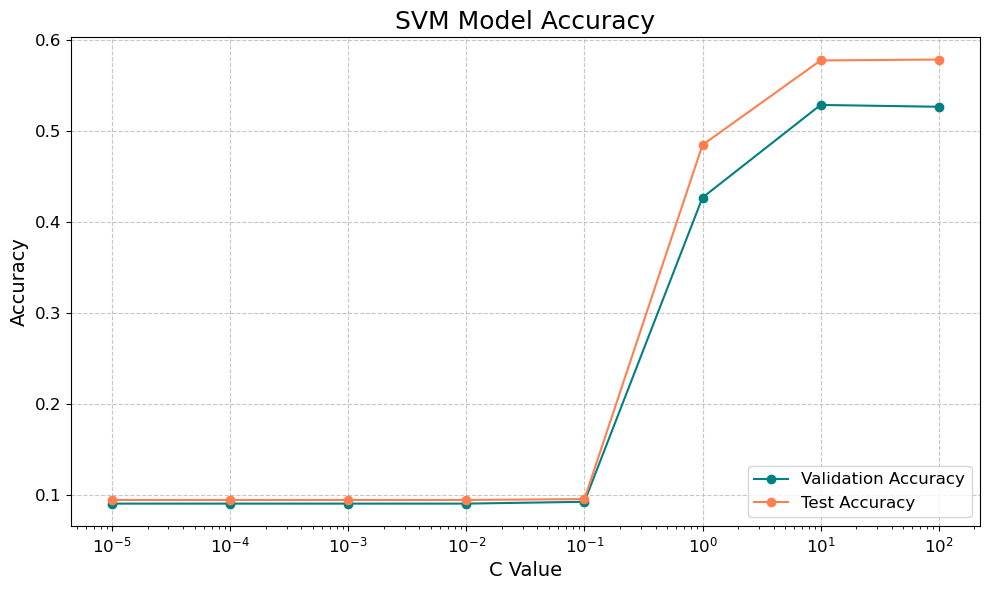

In [41]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, val_accuracies, marker='o', label='Validation Accuracy', color='teal')
plt.plot(C_values, test_accuracies, marker='o', label='Test Accuracy', color='coral')
plt.xscale('log')
plt.title('SVM Model Accuracy', fontsize=18)
plt.xlabel('C Value', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(C_values, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, title_fontsize=14, loc='lower right', frameon=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('svm_accuracy_c_values.png')
plt.show()

In [33]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier

In [34]:
#Iterate over max depth of decision tree
max_depths = [5, 10, 15, 20, 25]

# Create empty lists to store the results
val_accuracies = []
#Create subsets
X_train_comb_flat_small = X_train_comb_flat[:10000]
y_train_comb_small = y_train_comb[:10000]

# Iterate over the max_depths
for max_depth in tqdm(max_depths):
    # Create and fit the model
    rf_model = RandomForestClassifier(n_estimators=500, max_depth=max_depth, random_state=42)
    rf_model.fit(X_train_comb_flat_small, y_train_comb_small)
    #Get training accuracy
    train_accuracy = rf_model.score(X_train_comb_flat_small, y_train_comb_small)
    
    # Evaluate on the validation set
    val_accuracy = rf_model.score(X_val_comb_flat, y_val_comb)
    val_accuracies.append(val_accuracy)



100%|██████████| 5/5 [01:44<00:00, 20.87s/it]


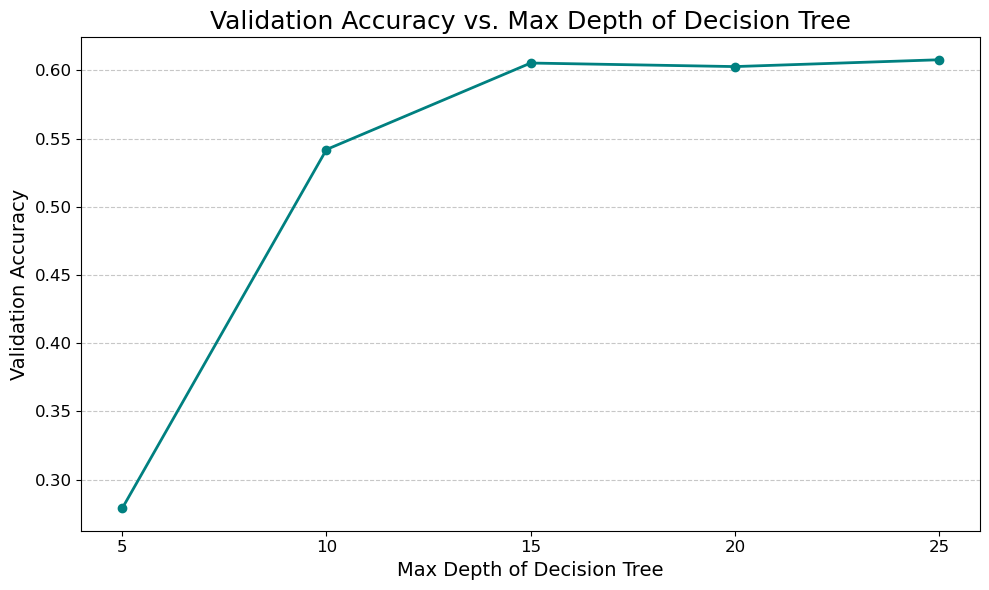

In [35]:
# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(max_depths, val_accuracies, marker='o', color='teal', linewidth=2)

plt.title('Validation Accuracy vs. Max Depth of Decision Tree', fontsize=18)
plt.xlabel('Max Depth of Decision Tree', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)      

plt.xticks(max_depths, fontsize=12) 
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('max_depths.png')
plt.show()

### (4) Linear Classifiers

In [36]:
# 1. Create a Logistic Regression model on the combined dataset (56x28)
log_reg_combined = LogisticRegression(solver='lbfgs', max_iter=10000)

In [37]:
# Train a Logistic Regression model on the individual images
log_reg_individual = LogisticRegression(solver='lbfgs', max_iter=10000)

In [38]:
#Repeat for increasing training size

train_sizes = [50, 100, 500, 1000]
accuracies = []
accuracies_combined = []

for train_size in train_sizes:
    # Get combined data with the specified training size
    X_train_comb_subset = X_train_comb_flat[:train_size]
    y_train_comb_subset = y_train_comb[:train_size]

    # Train a Logistic Regression model on the combined dataset
    log_reg_combined.fit(X_train_comb_subset, y_train_comb_subset)

    # Predict on the test set
    y_pred_combined = log_reg_combined.predict(X_test_comb_flat)

    # Calculate the accuracy
    accuracy_combined = np.mean(y_pred_combined == y_test_comb)
    accuracies_combined.append(accuracy_combined)

    # Print the results
    print(f"Training Size: {train_size}, Accuracy (Combined): {accuracy_combined:.6f}")

    #Now for individual images
    # Flatten MNIST 
    X_train_all_flat = X_train_all.reshape(X_train_all.shape[0], -1)
    X_test_all_flat = X_test_all.reshape(X_test_all.shape[0], -1)
    X_train_subset = X_train_all_flat[:train_size]
    y_train_subset = y_train_all[:train_size]

    log_reg_individual.fit(X_train_subset, y_train_subset)
    y_pred = log_reg_individual.predict(X_test_all_flat)

    accuracy = np.mean(y_pred == y_test_all)
    accuracies.append(accuracy)
    print(f"Training Size: {train_size}, Accuracy (Individual): {accuracy:.2f}")

Training Size: 50, Accuracy (Combined): 0.104500
Training Size: 50, Accuracy (Individual): 0.63
Training Size: 100, Accuracy (Combined): 0.114400
Training Size: 100, Accuracy (Individual): 0.68
Training Size: 500, Accuracy (Combined): 0.122800
Training Size: 500, Accuracy (Individual): 0.84
Training Size: 1000, Accuracy (Combined): 0.141300
Training Size: 1000, Accuracy (Individual): 0.86


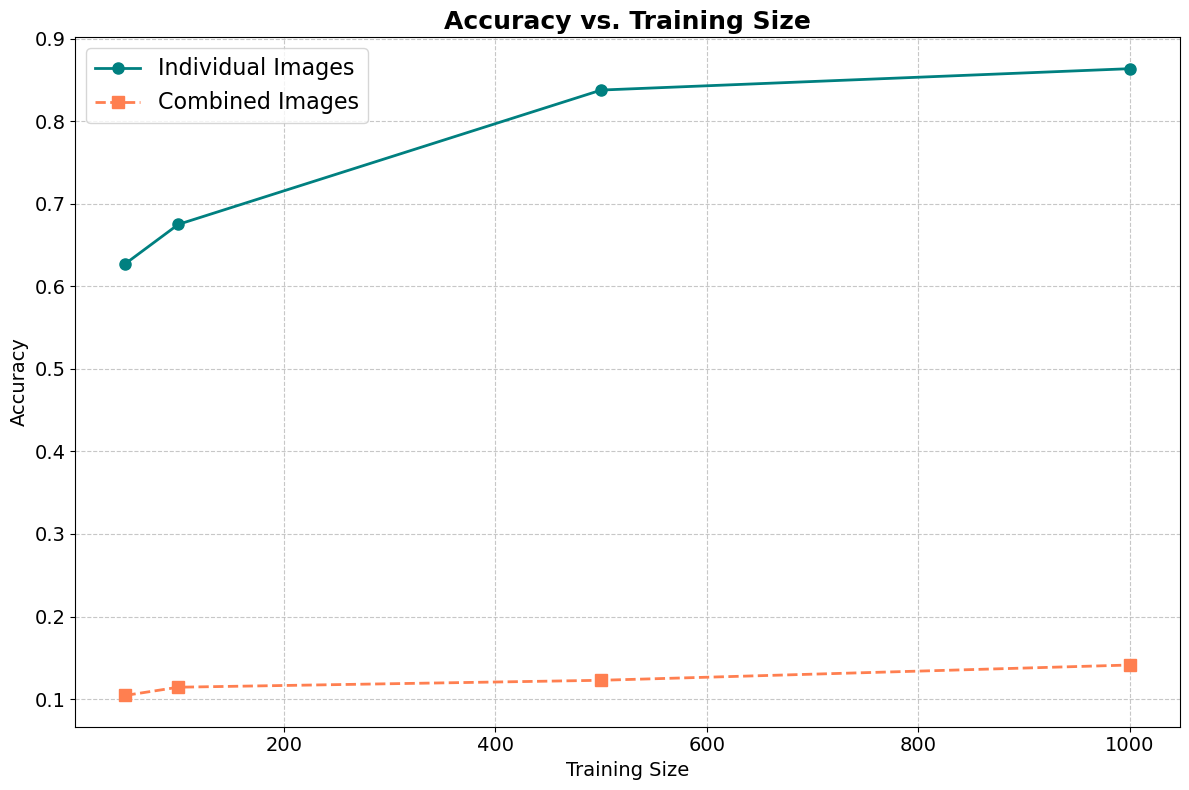

In [42]:
# Create the figure
plt.figure(figsize=(12, 8))

# Plot the data with enhanced formatting
plt.plot(train_sizes, accuracies, marker='o', linestyle='-', linewidth=2, markersize=8, label='Individual Images', color='teal')
plt.plot(train_sizes, accuracies_combined, marker='s', linestyle='--', linewidth=2, markersize=8, label='Combined Images', color='coral')

# Add titles and labels with appropriate fonts
plt.title('Accuracy vs. Training Size', fontsize=18, fontweight='bold')
plt.xlabel('Training Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, title_fontsize=14, loc='best', frameon=True)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_training_size.png')
plt.show()


# (5) t-SNE

In [43]:
import keras

In [65]:
# Load model to extract weights
model_opt = tf.keras.models.load_model('model_opt.h5')

# Extract weights
weights = model_opt.get_weights()

# List all layers in the model to find the embedding layer
for i, layer in enumerate(model_opt.layers):
    print(f"Layer {i}: {layer.name}, {layer.__class__}")


#Extract embedding layer

dense_layers = [layer for layer in model_opt.layers if isinstance(layer, keras.layers.Dense)]
penultimate_dense_layer = dense_layers[-2]

print(f"Penultimate Dense Layer: {penultimate_dense_layer.name}")

embedding_model = Model(inputs=model_opt.input, outputs=model_opt.get_layer(penultimate_dense_layer.name).output)
#embedding_model = Model(inputs=model_opt.input, outputs=model_opt.get_layer('dense_628').output)

embeddings_model = embedding_model.predict(X_test_comb)  # X_test is your test data

Layer 0: flatten_142, <class 'keras.layers.reshaping.flatten.Flatten'>
Layer 1: dense_624, <class 'keras.layers.core.dense.Dense'>
Layer 2: dropout_482, <class 'keras.layers.regularization.dropout.Dropout'>
Layer 3: dense_625, <class 'keras.layers.core.dense.Dense'>
Layer 4: dropout_483, <class 'keras.layers.regularization.dropout.Dropout'>
Layer 5: dense_626, <class 'keras.layers.core.dense.Dense'>
Layer 6: dropout_484, <class 'keras.layers.regularization.dropout.Dropout'>
Layer 7: dense_627, <class 'keras.layers.core.dense.Dense'>
Layer 8: dropout_485, <class 'keras.layers.regularization.dropout.Dropout'>
Layer 9: dense_628, <class 'keras.layers.core.dense.Dense'>
Layer 10: dropout_486, <class 'keras.layers.regularization.dropout.Dropout'>
Layer 11: dense_629, <class 'keras.layers.core.dense.Dense'>
Layer 12: dropout_487, <class 'keras.layers.regularization.dropout.Dropout'>
Layer 13: dense_630, <class 'keras.layers.core.dense.Dense'>
Penultimate Dense Layer: dense_629
313/313 [=====

In [66]:
# t - SNE

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
embedding_tsne = tsne.fit_transform(embeddings_model)

In [67]:
#Apply t-SNE directly on input data
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedding_tsne_input = tsne.fit_transform(X_test_comb_flat)

In [68]:
# Visualize the t-SNE result

y_test = np.argmax(y_test_comb_cat, axis=1)

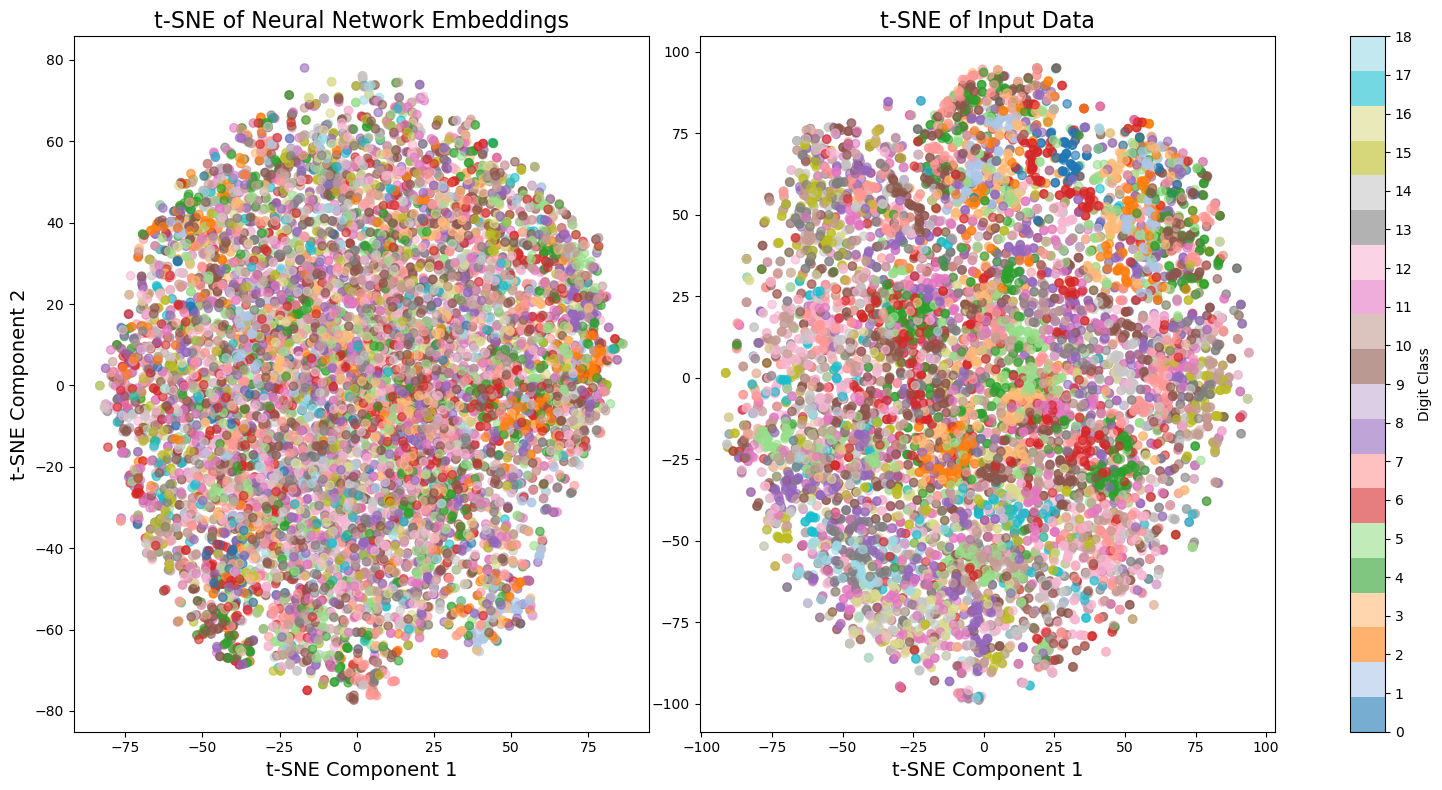

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot t-SNE of the neural network embeddings on the first subplot
scatter1 = axes[0].scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=y_test, cmap='tab20', 
                alpha=0.6, marker='o')
axes[0].set_title("t-SNE of Neural Network Embeddings", fontsize=16)
axes[0].set_xlabel('t-SNE Component 1', fontsize=14)
axes[0].set_ylabel('t-SNE Component 2', fontsize=14)

# Plot t-SNE of the input data on the second subplot
scatter2 = axes[1].scatter(embedding_tsne_input[:, 0], embedding_tsne_input[:, 1], c=y_test, cmap='tab20', 
                alpha=0.6, marker='o')
axes[1].set_title("t-SNE of Input Data", fontsize=16)
axes[1].set_xlabel('t-SNE Component 1', fontsize=14)

plt.tight_layout()
cbar = fig.colorbar(scatter1, ax=axes, orientation='vertical', ticks=range(19))
cbar.set_label('Digit Class')

plt.savefig('t-SNE.png')
plt.show()


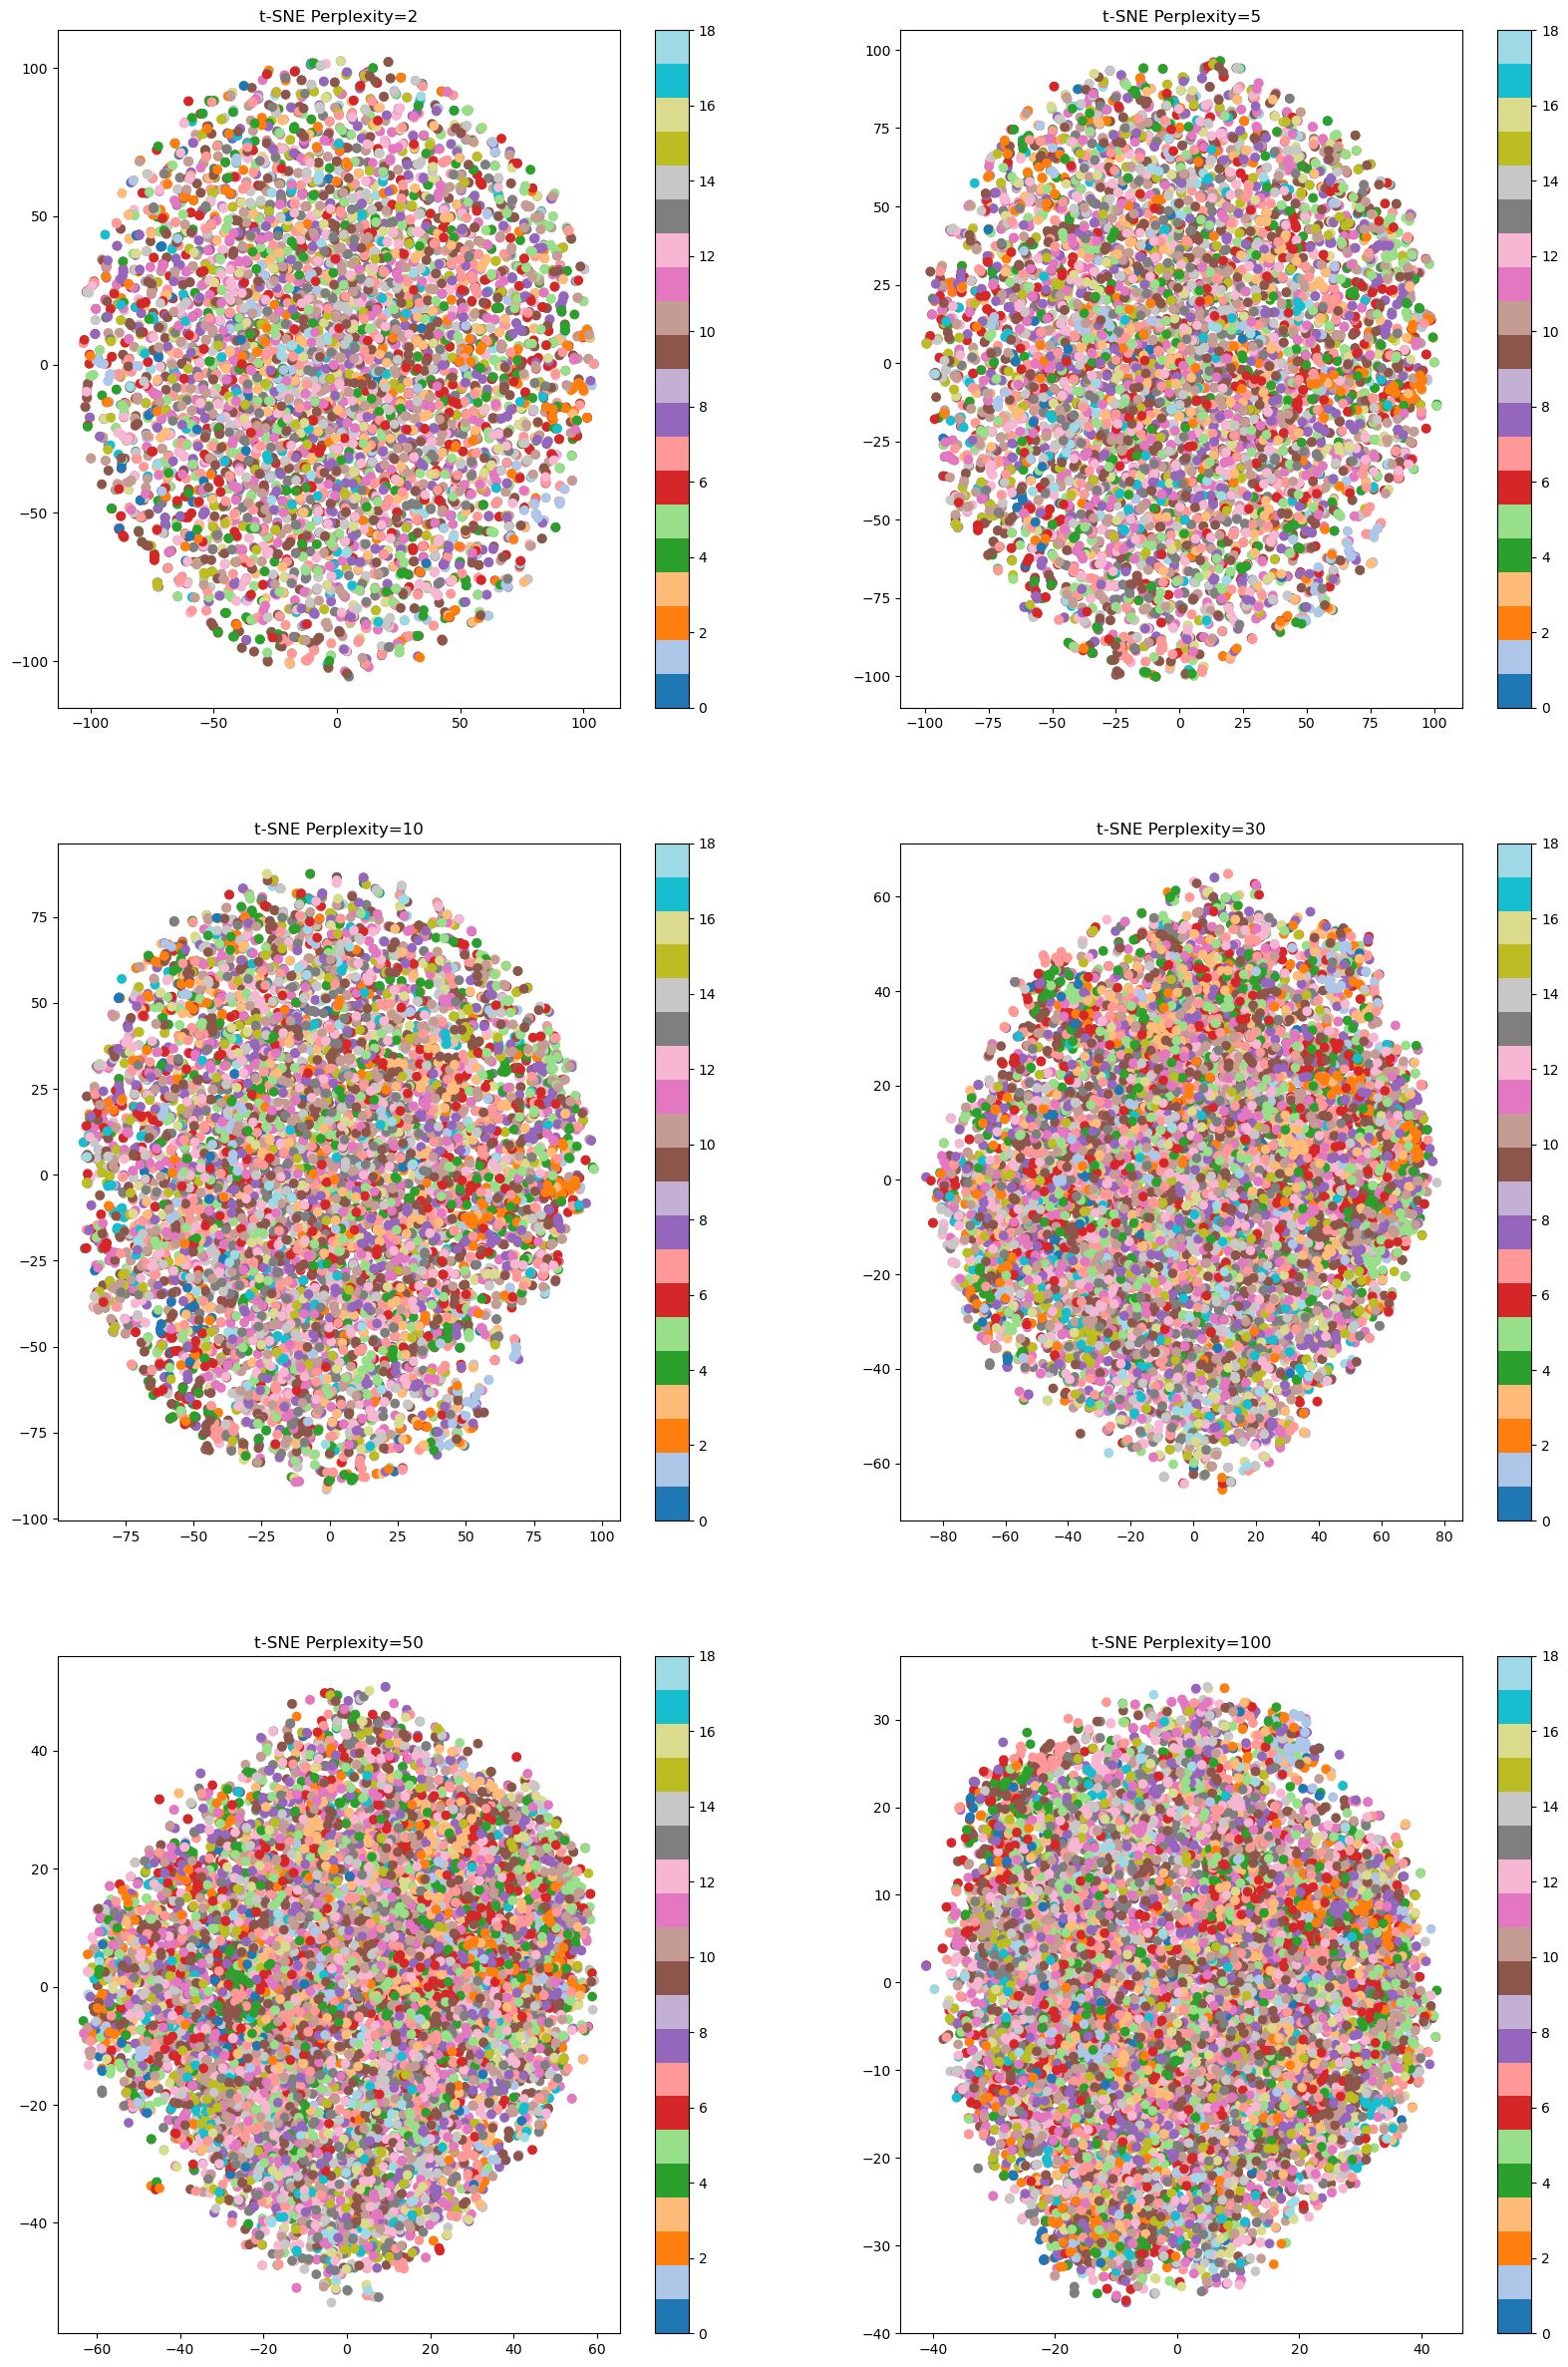

In [56]:
#Optimise perplexity 

perplexities = [2, 5, 10, 30, 50, 100]
kl_divergences = []

plt.figure(figsize=(20, 30))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    embedding_tsne = tsne.fit_transform(embeddings_model)
    #Track KL divergence
    kl_divergence = tsne.kl_divergence_
    kl_divergences.append(kl_divergence)

    plt.subplot(3, 2, i+1)
    plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=y_test, cmap='tab20')  # Color by true labels
    plt.colorbar()
    plt.title(f"t-SNE Perplexity={perplexity}")

In [ ]:
print(kl_divergences)

NameError: name 'KL_divergences' is not defined